In [1]:
import os
os.chdir('../..')

In [4]:
import numpy as np
import torch

from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from molexplain.utils import MODELS_PATH, PROCESSED_DATA_PATH, DEVICE

In [7]:
model = torch.load(os.path.join(MODELS_PATH, "AZ_ChEMBL_global.pt"), map_location=DEVICE)
inchis = np.load(os.path.join(PROCESSED_DATA_PATH, "inchis.npy"))

In [8]:
from rdkit.Chem import MolFromInchi

In [19]:
example_inchi = inchis[256]
print(example_inchi)

InChI=1S/C24H27N5O4S/c1-13(2)11-29-23-19(21(31)27(3)24(29)33)18(22(32)28-8-6-15(30)12-28)17(34-23)9-14-10-26-20-16(14)5-4-7-25-20/h4-5,7,10,13,15,30H,6,8-9,11-12H2,1-3H3,(H,25,26)/t15-/m1/s1


In [20]:
mol = MolFromInchi(example_inchi)

In [21]:
from molexplain.vis import molecule_importance
svg, global_importance = molecule_importance(mol, model, task=1, vis_factor=10)

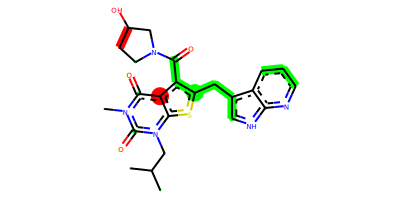

In [22]:
svg

In [18]:
global_importance

array([-0.02647237, -0.05888819,  0.05463789, -0.02819189], dtype=float32)

In [25]:
for a in mol.GetAtoms():
    print(a.GetSymbol())

C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
N
N
N
N
N
O
O
O
O
S
